## Description:

    Which OTUs are responding to multiple treatment effects or covariates 
   


# Setting variables

In [1]:
workDir = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2'
#using physeq file with sparsity of greater than 3 in 3 samples
physeqFile = '/home/bryan/ERA/data/MiSeq/20170417_run1/phyloseq/ERA_thresh.rds'

# Init

In [2]:
%load_ext rpy2.ipython

In [3]:
%%R
# The required package list:
reqpkg = c("plyr","BiocParallel","doParallel", "DESeq2", "foreach", "ggplot2", 
   "gridExtra","scales", "phyloseq", "dplyr", "tidyr", 
           "reshape2", "vegan", "RColorBrewer", "VennDiagram")
# Load all required packages and show version
for (i in reqpkg) {
    print(i)
    print(packageVersion(i))
    suppressMessages(library(i, quietly = TRUE, verbose = FALSE, 
                             warn.conflicts = FALSE, character.only = TRUE))
}

[1] "plyr"
[1] ‘1.8.4’
[1] "BiocParallel"
[1] ‘1.8.2’
[1] "doParallel"
[1] ‘1.0.10’
[1] "DESeq2"
[1] ‘1.14.1’
[1] "foreach"
[1] ‘1.4.3’
[1] "ggplot2"
[1] ‘2.2.1’
[1] "gridExtra"
[1] ‘2.2.1’
[1] "scales"
[1] ‘0.4.1’
[1] "phyloseq"
[1] ‘1.19.1’
[1] "dplyr"
[1] ‘0.5.0’
[1] "tidyr"
[1] ‘0.6.0’
[1] "reshape2"
[1] ‘1.4.2’
[1] "vegan"
[1] ‘2.4.3’
[1] "RColorBrewer"
[1] ‘1.1.2’
[1] "VennDiagram"
[1] ‘1.6.17’


In [4]:
%%R
register(MulticoreParam(20))

# Read log2fold change tables

In [5]:
%%R
enzT1 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t1_sig.csv')
enzT2 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t2_sig.csv')
enzT3 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_enzyme_t3_sig.csv')
fertT3 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_fert_t3.csv') %>%
    filter(padj < 0.05)


l2f.hybrid = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/EarlyReleasevsYear.csv') %>%
    filter(padj < 0.05)
l2f.RYear.2 = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_Year2.csv') %>%
    filter(padj < 0.05)

colnames(enzT1) %>% print
colnames(fertT3)%>% print
colnames(l2f.hybrid1939)%>% print
colnames(l2f.RYear.2) %>% print

 [1] "baseMean"       "log2FoldChange" "lfcSE"          "stat"          
 [5] "pvalue"         "padj"           "OTU"            "Rank1"         
 [9] "Rank2"          "Rank3"          "Rank4"          "Rank5"         
[13] "Rank6"          "Rank7"          "Rank8"          "test"          
 [1] "X"              "baseMean"       "log2FoldChange" "lfcSE"         
 [5] "stat"           "pvalue"         "padj"           "OTU"           
 [9] "Contrast"       "Rank1"          "Rank2"          "Rank3"         
[13] "Rank4"          "Rank5"          "Rank6"          "Rank7"         
[17] "Rank8"
Error in colnames(l2f.hybrid1939) : object 'l2f.hybrid1939' not found


/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Error in colnames(l2f.hybrid1939) : object 'l2f.hybrid1939' not found

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: In addition: 
  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Warning messages:

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 1: package ‘S4Vectors’ was built under R version 3.3.3 

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 2: package ‘IRanges’ was built under R version 3.3.3 

  warnings.warn(x, RRuntimeWarning)
/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: 3: p

## OTUs positively correlated with enzyme activity

In [6]:
%%R
enzT1$TimePoint = "T1"
enzT2$TimePoint = "T2"
enzT3$TimePoint = "T3"

* Axis 1 is positively correlated with total activity at T1 and negatively correlated at T2 and T3
* Axis 2 is negatively correlated with LAP at T1, T2 and postively correlated at T3
* We are interested in all OTUs correlated as even a negative correlation indicates a shift in activity.  

In [7]:
%%R
enzT1$TimePoint = "T1"
enzT2$TimePoint = "T2"
enzT3$TimePoint = "T3"


In [8]:
%%R
Enz = bind_rows(enzT1, enzT2, enzT3)
dim(Enz)

EnzOTUs = Enz %>% select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique 
paste(EnzOTUs %>% dim %>% .[1], " OTUs correlated with changes in enzyme activity")

[1] "34  OTUs correlated with changes in enzyme activity"


## OTUs differentially abundant between early release and any other genotype 

* Currently 1939 comparison at V6 and R3 and 1936 comparison at R1

In [9]:
%%R

# l2f.hybridT2 not necessary?
HybridOTUs = l2f.hybrid %>%
#bind_rows(l2f.hybrid,  l2f.RYear.2) %>% 
        select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
        #.$OTU %>% unique
paste(HybridOTUs  %>% dim %>% .[1], " OTUs differntially abundant between genotypes")


[1] "48  OTUs differntially abundant between genotypes"


## OTUs responding to fertilizer at T3

In [10]:
%%R
FertIncrease = fertT3 %>% filter(padj < 0.05 & log2FoldChange > 0) %>% 
     select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
FertDecrease = fertT3 %>% filter(padj < 0.05 & log2FoldChange < 0) %>% 
     select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
paste(FertIncrease %>% dim %>% .[1], " OTUs enriched in fertilized rhizosphere at T3") %>% print
paste(FertDecrease %>% dim %>% .[1], " OTUs enriched in depleted in rhizosphere at T3")

[1] "88  OTUs enriched in fertilized rhizosphere at T3"
[1] "23  OTUs enriched in depleted in rhizosphere at T3"


## Rhizosphere responders

In [11]:
%%R
RhizResp = read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/BarevsHybrid.csv') %>%
    filter(p.adj < 0.05 & log2FoldChange > 0) %>% 
    select(OTU, Rank2, Rank3, Rank4, Rank5, Rank6, Rank7, Rank8) %>% unique
    

paste(RhizResp %>% dim %>% .[1], " OTUs enriched in rhizosphere")


[1] "284  OTUs enriched in rhizosphere"


# Shared OTUs

In [12]:
%%R
# OTUs that are related to enzyme activity and differentially abundant between genotypes
semi_join(EnzOTUs,HybridOTUs, by = "OTU")

      OTU            Rank2                 Rank3              Rank4
1 OTU.314 __Proteobacteria __Alphaproteobacteria  __Caulobacterales
2 OTU.630 __Proteobacteria __Alphaproteobacteria __Sphingomonadales
3 OTU.311 __Actinobacteria      __Acidimicrobiia __Acidimicrobiales
                 Rank5                Rank6                  Rank7 Rank8
1   __Caulobacteraceae      __Asticcacaulis                   <NA>    NA
2 __Erythrobacteraceae __Altererythrobacter                   <NA>    NA
3          __Iamiaceae              __Iamia __uncultured_bacterium    NA


In [13]:
%%R
# OTUs that are related to enzyme activity and enriched in fertilizer treatment
semi_join(EnzOTUs,FertIncrease, by = "OTU")

      OTU            Rank2                 Rank3             Rank4
1 OTU.314 __Proteobacteria __Alphaproteobacteria __Caulobacterales
               Rank5           Rank6 Rank7 Rank8
1 __Caulobacteraceae __Asticcacaulis  <NA>    NA


In [14]:
%%R
# OTUs that are related to enzyme activity and decreased abundance in fertilizer treatment
semi_join(EnzOTUs,FertDecrease, by = "OTU")

[1] OTU   Rank2 Rank3 Rank4 Rank5 Rank6 Rank7 Rank8
<0 rows> (or 0-length row.names)


In [15]:
%%R
# OTUs differentially abundant between genotypes and enriched in fertilizer treatments
semi_join(HybridOTUs,FertIncrease, by = "OTU") %>% unique 

         OTU             Rank2                 Rank3                  Rank4
1  OTU.14139  __Proteobacteria __Alphaproteobacteria          __Rhizobiales
2    OTU.119  __Proteobacteria  __Betaproteobacteria      __Burkholderiales
3   OTU.3521  __Proteobacteria  __Betaproteobacteria      __Burkholderiales
4   OTU.4313  __Proteobacteria __Gammaproteobacteria      __Pseudomonadales
5    OTU.371 __Verrucomicrobia    __OPB35_soil_group __uncultured_bacterium
6    OTU.314  __Proteobacteria __Alphaproteobacteria      __Caulobacterales
7    OTU.357  __Proteobacteria __Gammaproteobacteria    __Enterobacteriales
8    OTU.923  __Proteobacteria __Gammaproteobacteria      __Xanthomonadales
9     OTU.93  __Proteobacteria __Gammaproteobacteria      __Xanthomonadales
10   OTU.459      __Firmicutes             __Bacilli           __Bacillales
11    OTU.80  __Actinobacteria __Propionibacteriales      __Nocardioidaceae
                      Rank5                  Rank6                     Rank7
1          

In [16]:
%%R
# OTUs differentially abundant between genotypes and depleted in fertilizer treatments
semi_join(HybridOTUs,FertDecrease, by = "OTU")

[1] OTU   Rank2 Rank3 Rank4 Rank5 Rank6 Rank7 Rank8
<0 rows> (or 0-length row.names)


** There was no overlap between OTUs depleted in fertilized plots and those OTUs correlated with enzyme activity or those differentially abundant between hybrids

# Three way venn diagram
* Enzyme OTUs
* Fertilizer OTUs
* Genotype OTUs

(polygon[GRID.polygon.11], polygon[GRID.polygon.12], polygon[GRID.polygon.13], polygon[GRID.polygon.14], polygon[GRID.polygon.15], polygon[GRID.polygon.16], text[GRID.text.17], text[GRID.text.18], text[GRID.text.19], text[GRID.text.20], text[GRID.text.21], text[GRID.text.22], text[GRID.text.23], text[GRID.text.24], text[GRID.text.25]) 


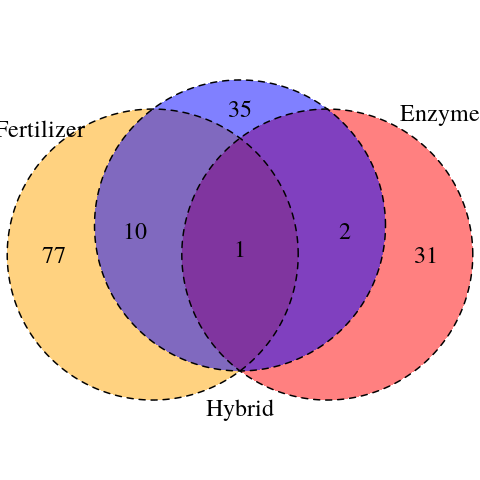

In [17]:
%%R
#area 1 = hybrid
#area 2 = Fert
#area 3 = Enzyme
draw.triple.venn(area1 = 48, area2 = 88, area3 = 34,
n12 = 11,
n23 = 1,
n13 = 3,
n123 = 1, category = c("Hybrid", "Fertilizer", "Enzyme"), lty = rep(2, 3), 
                 fill = c("blue", "orange", "red"), cex = 2,
                   cat.dist = .05, cat.cex = 2, scaled = TRUE, rotation.degree = 0, euler.d = TRUE)

* Note that there is no overlap between OTUs depleted in fertilizer treatment and either hybrids or enzymes; venn diagram only accounts for OTUs increasing in abundance

# Expore overlap betwen hybrid and fertilizer effects

In [18]:
%%R
FertIncrease

          OTU                    Rank2                  Rank3
1    OTU.2489         __Proteobacteria  __Deltaproteobacteria
2   OTU.14139         __Proteobacteria  __Alphaproteobacteria
3   OTU.15685         __Proteobacteria  __Alphaproteobacteria
4      OTU.69         __Proteobacteria  __Alphaproteobacteria
5      OTU.78         __Proteobacteria  __Alphaproteobacteria
6    OTU.3468         __Proteobacteria  __Alphaproteobacteria
7     OTU.495         __Proteobacteria  __Alphaproteobacteria
8     OTU.287          __Bacteroidetes     __Sphingobacteriia
9     OTU.267          __Bacteroidetes     __Sphingobacteriia
10    OTU.119         __Proteobacteria   __Betaproteobacteria
11   OTU.5502         __Proteobacteria   __Betaproteobacteria
12  OTU.11319         __Proteobacteria   __Betaproteobacteria
13   OTU.3521         __Proteobacteria   __Betaproteobacteria
14     OTU.11         __Proteobacteria   __Betaproteobacteria
15   OTU.5756         __Proteobacteria   __Betaproteobacteria
16     O

In [19]:
%%R
inner_join(l2f.hybrid,FertIncrease) 

/home/bryan/anaconda3/lib/python3.6/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Joining, by = c("OTU", "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7", "Rank8")

  warnings.warn(x, RRuntimeWarning)


     baseMean log2FoldChange     lfcSE       pvalue        padj       OTU Plant
1    7.665748      -1.698689 0.3993900 2.107304e-05 0.024764686  OTU.3521  3517
2    9.123596      -1.644914 0.4071804 5.350445e-05 0.032784852  OTU.4313  3517
3    7.972103       2.616176 0.6373699 4.049390e-05 0.008090792   OTU.314  3517
4    5.084167       2.656703 0.6070984 1.208401e-05 0.006355854   OTU.923  3517
5   25.658440       1.502952 0.3960808 1.479053e-04 0.021224417   OTU.371  3517
6   59.221234       1.651126 0.3807162 1.445099e-05 0.008391211    OTU.80  3541
7   15.672988       2.732895 0.6408571 2.004064e-05 0.025773286 OTU.14139  3618
8  112.795336       2.697696 0.6168771 1.224662e-05 0.025773286   OTU.119  3618
9   14.281718       2.673511 0.6364114 2.658379e-05 0.025773286   OTU.357  3618
10  15.568230       2.646539 0.6318672 2.808771e-05 0.025773286   OTU.459  3618
11  87.711152       1.023373 0.2088300 9.558852e-07 0.004387513    OTU.93  3475
   TimePoint    Rank1             Rank2 

# Format tables for supplementary
* Start with hybrid effects, then add fertilizer and enzymes

In [20]:
%%R
H = l2f.hybrid %>% mutate(Test = "Hybrid") %>%
    arrange(desc(OTU)) 
colnames(H)[c(1:5,7,8,17)] = paste("hybrid", "-",colnames(H[c(1:5,7,8,17)]) )

In [21]:
%%R
F = fertT3 %>% 
    select(-X) %>% #-Rank1,-Rank2, -Rank3, -Rank4, -Rank5, -Rank6,-Rank7, -Rank8 ) %>%
    mutate(Test = "Fertilizer") %>%
    arrange(desc(OTU)) 
#colnames(F)
colnames(F)[c(1:6,8,17)] = paste("Fertilizer", "-",colnames(F[c(1:6,8,17)]) )

In [22]:
%%R

read.csv('/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/l2f_fert_t3.csv') %>% 
    group_by(Contrast) %>%
    summarize(Ndepth = sum(baseMean)) %>%
    .$Ndepth %>%
    unique() %>%
paste(.,"normalized reads at each contrast") %>% print




[1] "33535.0243078956 normalized reads at each contrast"


In [23]:
%%R
E = Enz %>% 
   # select(-Rank1,-Rank2, -Rank3, -Rank4, -Rank5, -Rank6,-Rank7, -Rank8 ) %>%
    arrange(desc(OTU)) 

colnames(E)[c(1:6,16,17)] = paste("Enzyme", "-",colnames(E[c(1:6,8,16,17)]) )
colnames(E)

 [1] "Enzyme - baseMean"       "Enzyme - log2FoldChange"
 [3] "Enzyme - lfcSE"          "Enzyme - stat"          
 [5] "Enzyme - pvalue"         "Enzyme - padj"          
 [7] "OTU"                     "Rank1"                  
 [9] "Rank2"                   "Rank3"                  
[11] "Rank4"                   "Rank5"                  
[13] "Rank6"                   "Rank7"                  
[15] "Rank8"                   "Enzyme - Rank1"         
[17] "Enzyme - test"          


* Make enzyme axis explicit? 

In [24]:
%%R
H %>% head

  hybrid - baseMean hybrid - log2FoldChange hybrid - lfcSE hybrid - pvalue
1          2.990913                2.244707      0.6177892    2.796550e-04
2          9.298076                1.709678      0.4059691    2.538494e-05
3          3.337030               -1.662755      0.3549319    2.803505e-06
4         87.711152                1.023373      0.2088300    9.558852e-07
5          7.368062                1.888453      0.4201406    6.963110e-06
6          5.084167                2.656703      0.6070984    1.208401e-05
  hybrid - padj      OTU hybrid - Plant hybrid - TimePoint    Rank1
1   0.031212606  OTU.966           3517                 T2 Bacteria
2   0.038838954  OTU.950           3475                 T3 Bacteria
3   0.006372368  OTU.948          34M95                 T1 Bacteria
4   0.004387513   OTU.93           3475                 T3 Bacteria
5   0.031960676 OTU.9266          34M95                 T3 Bacteria
6   0.006355854  OTU.923           3517                 T2 Bacteria

In [25]:
%%R
tmp = NULL
Tbl = NULL

In [26]:
%%R
tmp = full_join(H,F, by = c("OTU",  "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7")) 

Tbl = full_join(tmp, E, by = c("OTU", "Rank2", "Rank3", "Rank4", "Rank5", "Rank6", "Rank7"))
tmp = NULL
Tbl = Tbl %>% unique
dim(Tbl) %>% print
head(Tbl) 

[1] 204  37
  hybrid - baseMean hybrid - log2FoldChange hybrid - lfcSE hybrid - pvalue
1          2.990913                2.244707      0.6177892    2.796550e-04
2          9.298076                1.709678      0.4059691    2.538494e-05
3          3.337030               -1.662755      0.3549319    2.803505e-06
4         87.711152                1.023373      0.2088300    9.558852e-07
5          7.368062                1.888453      0.4201406    6.963110e-06
6          5.084167                2.656703      0.6070984    1.208401e-05
  hybrid - padj      OTU hybrid - Plant hybrid - TimePoint  Rank1.x
1   0.031212606  OTU.966           3517                 T2 Bacteria
2   0.038838954  OTU.950           3475                 T3 Bacteria
3   0.006372368  OTU.948          34M95                 T1 Bacteria
4   0.004387513   OTU.93           3475                 T3 Bacteria
5   0.031960676 OTU.9266          34M95                 T3 Bacteria
6   0.006355854  OTU.923           3517                

In [27]:
%%R
colnames(Tbl)

 [1] "hybrid - baseMean"           "hybrid - log2FoldChange"    
 [3] "hybrid - lfcSE"              "hybrid - pvalue"            
 [5] "hybrid - padj"               "OTU"                        
 [7] "hybrid - Plant"              "hybrid - TimePoint"         
 [9] "Rank1.x"                     "Rank2"                      
[11] "Rank3"                       "Rank4"                      
[13] "Rank5"                       "Rank6"                      
[15] "Rank7"                       "Rank8.x"                    
[17] "hybrid - Test"               "Fertilizer - baseMean"      
[19] "Fertilizer - log2FoldChange" "Fertilizer - lfcSE"         
[21] "Fertilizer - stat"           "Fertilizer - pvalue"        
[23] "Fertilizer - padj"           "Fertilizer - Contrast"      
[25] "Rank1.y"                     "Rank8.y"                    
[27] "Fertilizer - Test"           "Enzyme - baseMean"          
[29] "Enzyme - log2FoldChange"     "Enzyme - lfcSE"             
[31] "Enzyme - stat"     

In [28]:
%%R
Tbl[,c(2,5, 6, 17, 19, 23, 24, 25, 27, 31, 32, 33)] %>% filter(OTU == "OTU.10")# arrange(desc(OTU)) %>% head


  hybrid - log2FoldChange hybrid - padj    OTU hybrid - Test
1                      NA            NA OTU.10          <NA>
2                      NA            NA OTU.10          <NA>
  Fertilizer - log2FoldChange Fertilizer - padj Fertilizer - Contrast  Rank1.y
1                    1.421900      4.605522e-06                  0_85 Bacteria
2                    2.325644      8.863696e-18                 0_170 Bacteria
  Fertilizer - Test Enzyme - stat Enzyme - pvalue Enzyme - padj
1        Fertilizer            NA              NA            NA
2        Fertilizer            NA              NA            NA


In [29]:
%%R
write.csv(Tbl, file = '/home/bryan/ERA/data/MiSeq/20170417_run1/DESeq2/OTUIntersectionTbl.csv', row.names = FALSE)

# Explore 4 way intersection with rhizosphere responders highlighted

In [30]:
%%R
# OTUs differentially abundant between genotypes and rhizosphere responders 


NULL


In [31]:

# draw.quad.venn(area1, area2, area3, area4, n12, n13, n14, n23, n24,
# n34, n123, n124, n134, n234, n1234, category = rep("",
# 4), lwd = rep(2, 4), lty = rep("solid", 4), col =
# rep("black", 4), fill = NULL, alpha = rep(0.5, 4),
# label.col = rep("black", 15), cex = rep(1, 15),
# fontface = rep("plain", 15), fontfamily = rep("serif",
# 15), cat.pos = c(-15, 15, 0, 0), cat.dist = c(0.22,
# 0.22, 0.11, 0.11), cat.col = rep("black", 4), cat.cex
# = rep(1, 4), cat.fontface = rep("plain", 4),
# cat.fontfamily = rep("serif", 4), cat.just =
# rep(list(c(0.5, 0.5)), 4), rotation.degree = 0,
# rotation.centre = c(0.5, 0.5), ind = TRUE, cex.prop =
# NULL, print.mode = "raw", sigdigs = 3, direct.area =



In [32]:
%%R
RH = semi_join(HybridOTUs,RhizResp, by = "OTU")
RF = semi_join(RhizResp, FertIncrease, by = "OTU")
RE = semi_join(EnzOTUs,RhizResp, by = "OTU")
HF = semi_join (HybridOTUs, FertIncrease, by = "OTU")
HE = semi_join(HybridOTUs, EnzOTUs, by = "OTU")
FE = semi_join(FertIncrease, EnzOTUs, by = "OTU")
RHF = semi_join(RhizResp, HF, by = "OTU")
RHE = semi_join(RH, EnzOTUs, by = "OTU")
RFE = semi_join(RF, EnzOTUs, by = "OTU")
HFE = semi_join(HF, EnzOTUs, by = "OTU")
RHFE = semi_join(RhizResp, HFE, by = "OTU")

In [33]:
%%R
area1 = RhizResp %>% dim %>% .[1]
area2 = HybridOTUs %>% dim %>% .[1]
area3 = FertIncrease %>% dim %>% .[1]
area4 = EnzOTUs %>% dim %>% .[1]
n12 = RH %>% dim %>% .[1] # see cells above
n13 = RF %>% dim() %>% .[1]
n14 = RE %>% dim() %>% .[1]
n23 = HF %>% dim() %>% .[1]
n24 = HE %>% dim() %>% .[1]
n34 = FE %>% dim() %>% .[1]
n123 = RHF %>% dim() %>% .[1]
n124 = RHE %>% dim() %>% .[1]
n134 = RFE %>% dim() %>% .[1]
n234 = HFE %>% dim() %>% .[1]
n1234 = RHFE %>% dim() %>% .[1]



(polygon[GRID.polygon.26], polygon[GRID.polygon.27], polygon[GRID.polygon.28], polygon[GRID.polygon.29], polygon[GRID.polygon.30], polygon[GRID.polygon.31], polygon[GRID.polygon.32], polygon[GRID.polygon.33], text[GRID.text.34], text[GRID.text.35], text[GRID.text.36], text[GRID.text.37], text[GRID.text.38], text[GRID.text.39], text[GRID.text.40], text[GRID.text.41], text[GRID.text.42], text[GRID.text.43], text[GRID.text.44], text[GRID.text.45], text[GRID.text.46], text[GRID.text.47], text[GRID.text.48], text[GRID.text.49], text[GRID.text.50], text[GRID.text.51], text[GRID.text.52]) 


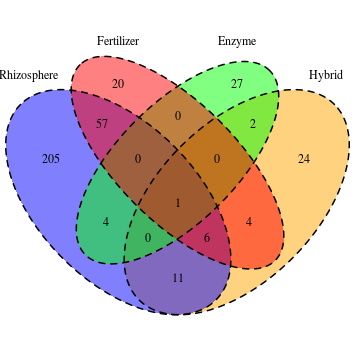

In [34]:
%%R -w 355 -h 355
draw.quad.venn(area1, area2, area3, area4, n12, n13, n14, n23, n24,
n34, n123, n124, n134, n234, n1234, category = c("Rhizosphere", "Hybrid", "Fertilizer", "Enzyme"), 
               lwd = rep(2, 4), lty = rep(2, 4), col = rep("black", 4), 
                 fill = c("blue", "orange", "red", "green"), alpha = rep(0.5, 4),
label.col = rep("black", 15), cex = rep(1, 15),
fontface = rep("plain", 15), fontfamily = rep("serif",
15), cat.pos = c(-15, 15, 0, 0), cat.dist = c(0.22,
0.22, 0.11, 0.11), cat.col = rep("black", 4), cat.cex
= rep(1, 4), cat.fontface = rep("plain", 4),
cat.fontfamily = rep("serif", 4), cat.just =
rep(list(c(0.5, 0.5)), 4), rotation.degree = 0,
rotation.centre = c(0.5, 0.5), ind = TRUE, cex.prop =
NULL, print.mode = "raw", sigdigs = 3)


In [38]:
%%R
?svg

R Help on ‘svg’cairo                package:grDevices                 R Documentation

_C_a_i_r_o_g_r_a_p_h_i_c_s-_b_a_s_e_d _S_V_G, _P_D_F _a_n_d _P_o_s_t_S_c_r_i_p_t _G_r_a_p_h_i_c_s _D_e_v_i_c_e_s

_D_e_s_c_r_i_p_t_i_o_n:

     Graphics devices for SVG, PDF and PostScript graphics files using
     the cairo graphics API.

_U_s_a_g_e:

     svg(filename = if(onefile) "Rplots.svg" else "Rplot%03d.svg",
         width = 7, height = 7, pointsize = 12,
         onefile = FALSE, family = "sans", bg = "white",
         antialias = c("default", "none", "gray", "subpixel"))
     
     cairo_pdf(filename = if(onefile) "Rplots.pdf" else "Rplot%03d.pdf",
               width = 7, height = 7, pointsize = 12,
               onefile = FALSE, family = "sans", bg = "white",
               antialias = c("default", "none", "gray", "subpixel"),
               fallback_resolution = 300)
     
     cairo_ps(filename = if(onefile) "Rplots

In [39]:
%%R
svg(filename= '/home/bryan/ERA/data/figures/ms_versions/Venn.svg', width = 3.149, height = 3.149)

draw.quad.venn(area1, area2, area3, area4, n12, n13, n14, n23, n24,
n34, n123, n124, n134, n234, n1234, category = c("Rhizosphere", "Hybrid", "Fertilizer", "Enzyme"), 
               lwd = rep(2, 4), lty = rep(2, 4), col = rep("black", 4), 
                 fill = c("blue", "orange", "red", "green"), alpha = rep(0.5, 4),
label.col = rep("black", 15), cex = rep(1, 15),
fontface = rep("plain", 15), fontfamily = rep("serif",
15), cat.pos = c(-15, 15, 0, 0), cat.dist = c(0.22,
0.22, 0.11, 0.11), cat.col = rep("black", 4), cat.cex
= rep(1, 4), cat.fontface = rep("plain", 4),
cat.fontfamily = rep("serif", 4), cat.just =
rep(list(c(0.5, 0.5)), 4), rotation.degree = 0,
rotation.centre = c(0.5, 0.5), ind = TRUE, cex.prop =
NULL, print.mode = "raw", sigdigs = 3)
dev.off()

png 
  2 
